# Plotting ANN sampling data for alanine dipeptide

Here we plot and compare the various free energy surfaces obtained for alanine dipeptide in water using ANN sampling with different architectures and sampling parameters to show how the method is robust to user choice, and is also rapidly convergent.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

Define the different folders containing data and the corresponding network architecture and sweep intervals.

In [2]:
# Folder name, network hidden layers, sweep length. 
data = [
    ("5000_8_4", [8, 4], 5000),
    ("10000_8_4", [8, 4], 10000),
     ("5000_10_6", [10, 6], 5000),
    ("10000_10_6", [10, 6], 10000)
]

Loop through data, and generate contour plots and different time intervals for comparison

In [3]:
dt = 0.002 # Timestep in fs. 
times = np.array([100, 500, 1000, 2500, 5000, 10000]) # Times at which to plot FES (ps).

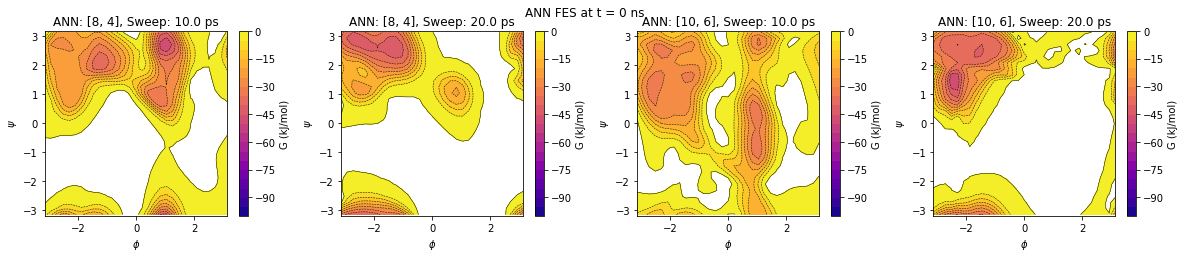

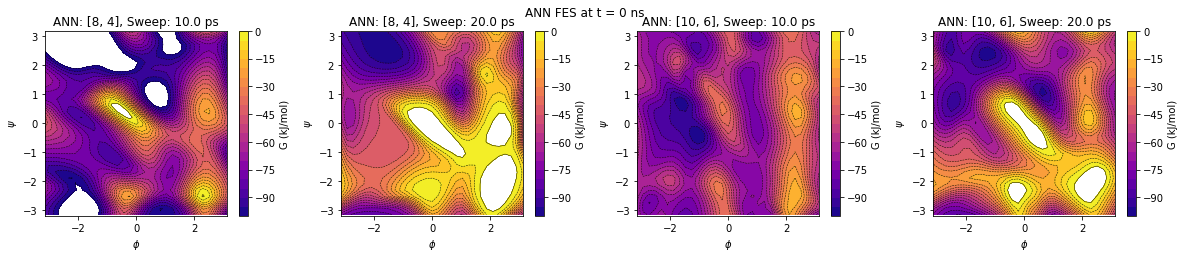

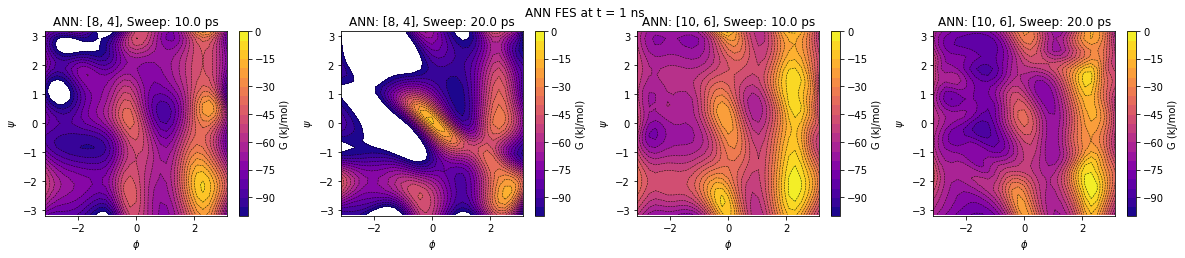

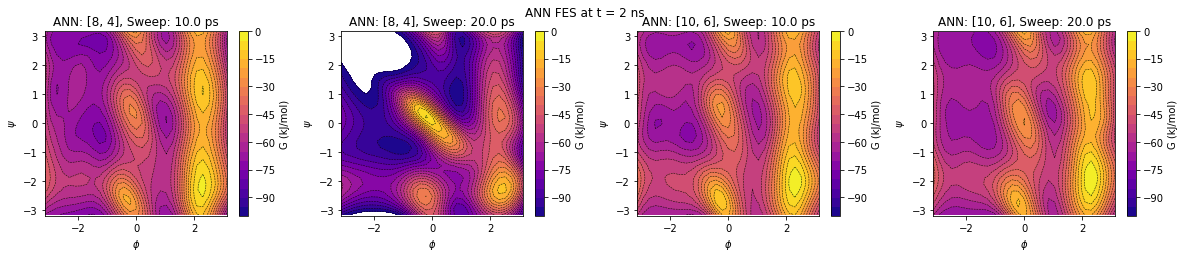

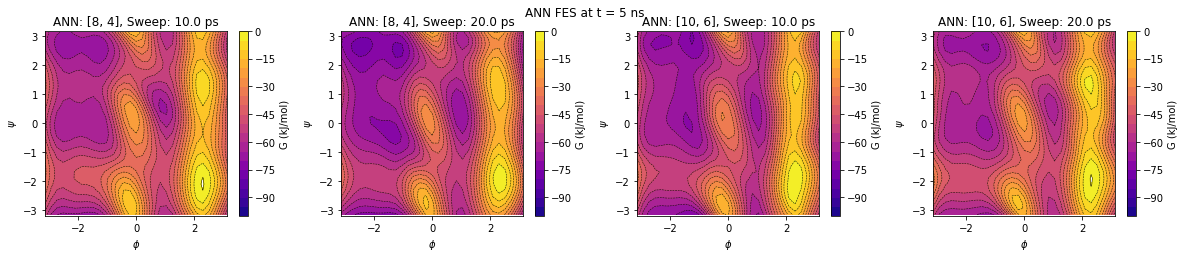

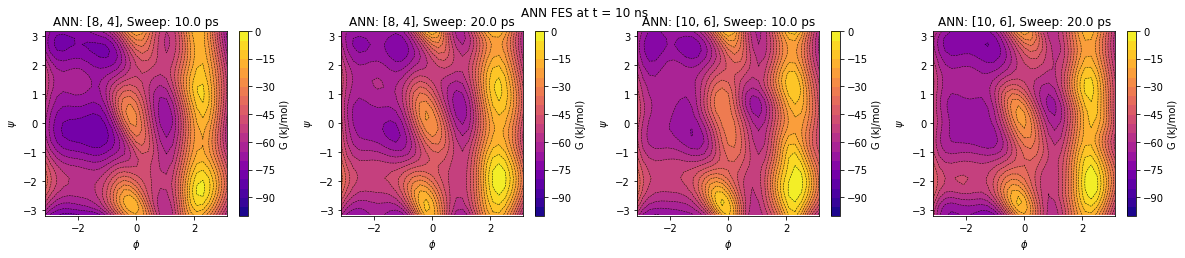

In [4]:
m = len(data)
v = np.arange(-100, 5, 5) # Contours to plot.
rmsd = [] # Collect RMSD between snapshots.
for t in times:
    fig = plt.figure(figsize=(20,3.4))
    fig.suptitle("ANN FES at t = {} ns".format(t/1000))
    mean_fes = np.zeros((31, 31))
    diff_fes = [np.zeros((31, 31))]*m
    i = 0
    for d in data:
        ax = fig.add_subplot(1, m, i+1)
        fig.subplots_adjust(wspace=0.3)
        folder, arch, sweep = d
        frame = int(t/(sweep*dt))
        
        # Load data and reshape into grid.
        X = np.loadtxt("{}/ann.dat{}".format(folder, frame))
        xg = np.reshape(X[:,0], (31, 31))
        yg = np.reshape(X[:,1], (31, 31))
        zg = np.reshape(-X[:,3], (31, 31))
        
        # PLot data.
        plt.title("ANN: [{}, {}], Sweep: {} ps".format(arch[0], arch[1], sweep*dt))
        plt.contour(xg, yg, zg, v, linewidths=0.5, colors="k")
        plt.contourf(xg, yg, zg, v, cmap=plt.cm.plasma)
        cb = plt.colorbar()
        cb.set_label("G (kJ/mol)")
        plt.xlabel("$\phi$")
        plt.ylabel("$\psi$")
        plt.xlim((-np.pi, np.pi))
        plt.ylim((-np.pi, np.pi))
        plt.axis("equal")
        
        # Accumulate mean and difference of FES's. 
        mean_fes += zg
        diff_fes[i] = zg
        
        i += 1
    
    # Comptue mean FES and RMSD. 
    mean_fes /= m
    rmsd.append(1./(m*31**2)*np.sum([np.sum((x-mean_fes)**2) for x in diff_fes]))